# Tokenization


## What is Tokenization and why do we need it?

### The Problem:

At its core, a Large Language Model (LLM) is a massive mathematical function. It performs matrix multiplications, applies activation functions, and calculates probabilities. You cannot multiply the word `"Apple"` by the number `0.5`. 

**Tokenization** is the process of converting raw text into a sequence of numbers (integers) that look up specific vectors in a database (embeddings). 

### Different Approaches
When designing a tokenizer, we face a "Goldilocks" problem:

#### 1. Character-Level (Too Small)
- **Idea:** Every individual character is a token (`a`, `b`, `c`...).
- **Pros:** Tiny vocabulary size (~100 tokens). No "unknown" words.
- **Cons:** Sequences become huge. The sentence "I like AI" becomes 9 tokens. Attention mechanisms become extremely slow.

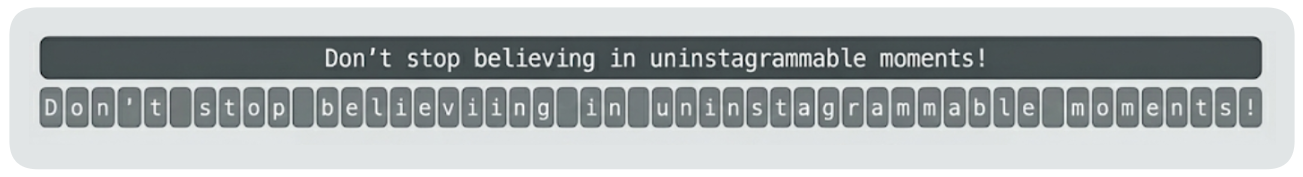

Problems:

The sequence is incredibly long for a short sentence.\
The model has to learn that `b` followed by `e` followed by `l` starts the concept of `belief`. It's very inefficient for the model to process.


#### 2. Word-Level (Too Big)
- **Idea:** Every word is a token (`apple`, `run`, `running`).
- **Pros:** Short sequences. Preserves semantic meaning.
- **Cons:** The English language has hundreds of thousands of words. If your vocabulary is limited to 50,000 words, seeing a rare word like "Uninstagrammable" breaks the model (resulting in an `[UNK]` token).

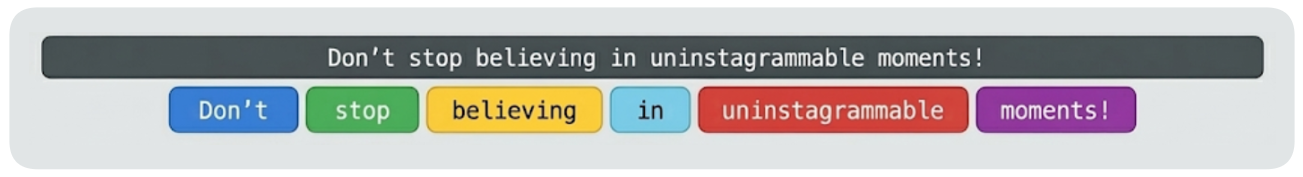

Problems:

Punctuation sticks to words. The model thinks `moments!` is a totally different word than `moments`.\
The rare word uninstagrammable is treated as a single, unique block. If the model hasn't seen exactly this word before, it becomes an "Unknown" (`[UNK]`) token, losing all meaning.

#### 3. Subword (Just Right)
- **Idea:** Break common words into whole tokens (`apple`), but break rare words into meaningful chunks (`un`, `friend`, `ly`).
- **Pros:** 
    - **Morphological Understanding:** The model understands that `un-` reverses meaning, even in words it has never seen before.
    - **Efficiency:** Keeps sequences short and vocabulary manageable (typically 32k - 100k tokens).

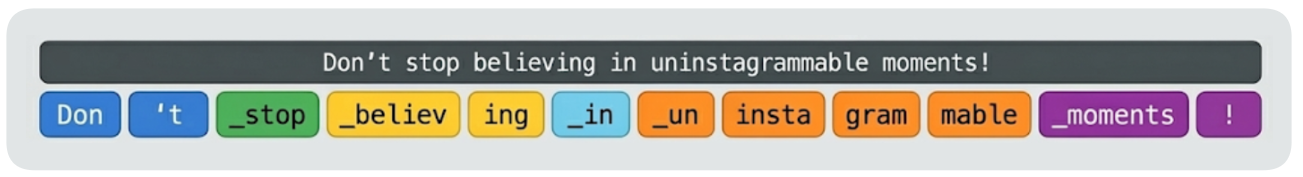

Why this is great:

Punctuation is handled: `Don't` is split, and the exclamation mark `!` is separate from `moments`.\
Morphology (Word structure): The model recognizes that `believing` is just the root concept of `believ` plus the present-tense suffix `ing`.\
Handling Rare Words: The model has likely never seen `uninstagrammable`. But it has seen `un` (not), `insta`, `gram`, and `mable` (able to be).\
By seeing these sub-tokens, it can understand the meaning of a word it has never encountered before.

# Byte Pair Encoding (BPE)

BPE was originally a compression algorithm.\
In NLP, it is one of the most used subword alogirhtms. It works by iteratively merging the most frequent adjacent pair of characters.

### How it Works (Step-by-Step)

1.  **Initialize:** Start with a vocabulary of only single characters.
2.  **Count:** Scan the entire corpus and count every adjacent pair of tokens (e.g., how often does `e` come after `h`?).
3.  **Merge:** Find the most frequent pair (e.g., `h` + `e` -> `he`). Add `he` to the vocabulary.
4.  **Replace:** Go back to the corpus and turn every instance of `h` followed by `e` into the single token `he`.
5.  **Repeat:** Do this until you reach a desired vocabulary size.

**The Effect:** 
Common patterns like `ing`, `tion`, `The` clump together early. Rare sequences remain as single letters.

###  Python Implementation (Optimized)

We will implement an optimized version of BPE. A naive implementation re-scans the entire text file (which could be gigabytes) every time it finds a new merge. That is too slow ($O(N^2)$).

**Our Optimizations:**
1.  **Pre-tokenization:** We split text into words once and count their ocurrences. `"hello hello world"` becomes `{"hello": 2, "world": 1}`. We process unique words, weighted by their frequency.
2.  **Inverted Index:** We map every pair to the list of words containing it. When we merge `('e', 's')`, we don't search the whole dataset; we go directly to the words containing that pair.

You can find this implementation in the _bpe.py_ file. 

### Experiment: Training on Synthetic Data

We will redefine the train method so that it is more verbose than the original implementation and we can print at every stage what is actually happening.\
First, let's add some paths to the python path so we can import these modules.

In [1]:
import sys
from pathlib import Path
sys.path.append(Path('').resolve().parent / 'src')
sys.path.append(Path('').resolve().parent / 'notes')

Now we can import our verbose implementation. We will be seeing the first initial stages of the algorithm, the first 3 steps of the merging logic, and after that every ten step, and then finally the last one.\
We will also use a "nonsense" corpus designed to force the tokenizer to learn specific patterns.

In [2]:
from settings import TokenizerSettings
from token_encoders.bpe import BPETokenizer
from tokenizer import bpe_verbose_train  # verbose implementation to log details
BPETokenizer.train = bpe_verbose_train

# Synthetic Corpus. Note the repetition of 'est', 'er', 'ug', 'un'
corpus = [
    "lowest lowest newer newer",
    "low er newest new est",
    "hug pug pun bun hugs",
    "hugs pugs puns buns",
    "huggy wuggy",
    "unfriend friendly friend",
]
# We want a small vocab to see the results easily
settings = TokenizerSettings(vocab_size=60, unused_tokens=0)
tokenizer = BPETokenizer(settings)
tokenizer.train(corpus)

# Display what it learned
print("\n--- Top 15 Learned Merges ---")
for i, merge in enumerate(tokenizer.merges[:15]):
    print(f"{i+1}. {merge} -> '{merge[0] + merge[1]}'")


STARTING BPE TRAINING ALGORITHM

[Phase 1] Pre-tokenization & Word Counting
  Processing raw text: 'lowest lowest newer newer'
    -> Parsed word: 'lowest' -> Tokens: ('l', 'o', 'w', 'e', 's', 't')
    -> Parsed word: 'Ġlowest' -> Tokens: ('Ġ', 'l', 'o', 'w', 'e', 's', 't')
    -> Parsed word: 'Ġnewer' -> Tokens: ('Ġ', 'n', 'e', 'w', 'e', 'r')
    -> Parsed word: 'Ġnewer' -> Tokens: ('Ġ', 'n', 'e', 'w', 'e', 'r')
  Processing raw text: 'low er newest new est'
    -> Parsed word: 'low' -> Tokens: ('l', 'o', 'w')
    -> Parsed word: 'Ġer' -> Tokens: ('Ġ', 'e', 'r')
    -> Parsed word: 'Ġnewest' -> Tokens: ('Ġ', 'n', 'e', 'w', 'e', 's', 't')
    -> Parsed word: 'Ġnew' -> Tokens: ('Ġ', 'n', 'e', 'w')
    -> Parsed word: 'Ġest' -> Tokens: ('Ġ', 'e', 's', 't')
  Processing raw text: 'hug pug pun bun hugs'
    -> Parsed word: 'hug' -> Tokens: ('h', 'u', 'g')
    -> Parsed word: 'Ġpug' -> Tokens: ('Ġ', 'p', 'u', 'g')
    -> Parsed word: 'Ġpun' -> Tokens: ('Ġ', 'p', 'u', 'n')
    -> Parsed wor

### Encoding and Decoding Test
Let's try to encode words that **were not** in the training set explicitly, but is made of parts that were.

In [3]:
def encode_decode(sentence: str):
    ids = tokenizer.encode(sentence)
    decoded = tokenizer.decode(ids)
    print(f"Original: {sentence}")
    print(f"IDs:      {ids}")
    print(f"Tokens:   {[tokenizer.inverse_vocab[i] for i in ids]}")
    print(f"Decoded:  {decoded}\n")
    
encode_decode("unfriendly hugger")

Original: unfriendly hugger
IDs:      [54, 49, 22, 29, 9, 7, 16]
Tokens:   ['unfriend', 'ly', 'Ġ', 'hug', 'g', 'e', 'r']
Decoded:  unfriendly hugger



Notice how the `[UNK]` token did not show up.\
Now let's try a sentence that contains words with no sub parts present in the corpus. 

In [4]:
encode_decode("batch normalization")

Original: batch normalization
IDs:      [5, 4, 18, 4, 10, 27, 14, 16, 4, 4, 12, 11, 4, 4, 18, 11, 14, 13]
Tokens:   ['b', '[UNK]', 't', '[UNK]', 'h', 'Ġn', 'o', 'r', '[UNK]', '[UNK]', 'l', 'i', '[UNK]', '[UNK]', 't', 'i', 'o', 'n']
Decoded:  b[UNK]t[UNK]h nor[UNK][UNK]li[UNK][UNK]tion



As you see, there are many unknown tokens since they were not seen at train time. Our small corpus did not contain all the letters in the English alphabet, so `a`,`c`,`m` and others are new to the tokenizer. \
Let's go and train with a bigger corpus. For this we need to switch to an implementation of BPE written in Rust which will be more faster.

### Rust vs. Python

If you run this Python code on half a GB of text, it might take hours. The Rust implementation that we have provided takes seconds or minutes depending on your setup. The main reasons for this are memory layout, algorihtmic differences and parallelism.\
If you want to take a look at how it has been implemented, you can find it in _rust/src/token_encoders/bpe.rs_.

Feel free to download any dataset or corpus available out there. I am using this [wikitext](https://huggingface.co/datasets/Salesforce/wikitext) available in Hugging Face.

In [5]:
from token_encoders.rust_bpe import RustBPETokenizer
import time 

corpus_file = Path("").resolve().parent / "data"/ "wikitext_103.txt"
text = corpus_file.read_text()

tokenizer = RustBPETokenizer(TokenizerSettings()) # default settings is fine now. 

start = time.time()
tokenizer.train([text])
end = time.time()

print(f"Trained on {len(text.split())} words in {end-start} seconds")

Trained on 101425671 words in 36.39619040489197 seconds


In [6]:
encode_decode("batch normalization")

Original: batch normalization
IDs:      [170, 6727, 9908, 6894]
Tokens:   ['b', 'atch', 'Ġnormal', 'ization']
Decoded:  batch normalization



As you see, now we can encode and decode batch normalization!\
Also note how the very common sub words `atch`, `normal` and `ization` have become individual tokens. \
Let's try with other sentences.

In [7]:
encode_decode("The quick brown fox jumps over the lazy dog.")
encode_decode("A single teaspoon of material from a neutron star would weigh approximately six billion tons on Earth.")
encode_decode("Unreal ppere words asdas in qweqwe a sentence par@434u789!.")

Original: The quick brown fox jumps over the lazy dog.
IDs:      [156, 5083, 7275, 9742, 18780, 24662, 5424, 5086, 5137, 25822, 9607, 118]
Tokens:   ['T', 'he', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġl', 'azy', 'Ġdog', '.']
Decoded:  The quick brown fox jumps over the lazy dog.

Original: A single teaspoon of material from a neutron star would weigh approximately six billion tons on Earth.
IDs:      [137, 6126, 5452, 16556, 6411, 5107, 7293, 5227, 5084, 21983, 6777, 5467, 14988, 8107, 6033, 9697, 8302, 5149, 8285, 118]
Tokens:   ['A', 'Ġsingle', 'Ġte', 'asp', 'oon', 'Ġof', 'Ġmaterial', 'Ġfrom', 'Ġa', 'Ġneutron', 'Ġstar', 'Ġwould', 'Ġweigh', 'Ġapproximately', 'Ġsix', 'Ġbillion', 'Ġtons', 'Ġon', 'ĠEarth', '.']
Decoded:  A single teaspoon of material from a neutron star would weigh approximately six billion tons on Earth.

Original: Unreal ppere words asdas in qweqwe a sentence par@434u789!.
IDs:      [157, 182, 11987, 20346, 5241, 8882, 5170, 172, 5113, 5109, 23942, 547